In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

pd.options.display.max_columns = 50

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def preprocess_df(file_path):

    file_path = 'data.csv'
    df = pd.read_csv(file_path)
    df = df.drop_duplicates()

    columns_to_exclude_max = ['sight_left', 'sight_right', 'SGOT_AST', 'gamma_GTP']
    for column in columns_to_exclude_max:
        df = df[df[column] != df[column].max()]

    sus_columns = ['waistline', 'BLDS', 'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'serum_creatinine', 'SGOT_AST',
                   'SGOT_ALT', 'gamma_GTP', 'hemoglobin']

    # Initialize a mask to select all rows initially
    mask = pd.Series([True] * df.shape[0])

    for column in sus_columns:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define the bounds for the outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Update the mask to identify rows that are not outliers in the current column
        mask = mask & (df[column] >= lower_bound) & (df[column] <= upper_bound)

    # Apply the mask to filter out the outliers
    df = df[mask]

    df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
    df['BMI_Category'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, float('inf')], labels=['0', '1', '2', '3'])
    df['MAP'] = df['DBP'] + (df['SBP'] - df['DBP']) / 3
    df['Liver_Enzyme_Ratio'] = df['SGOT_AST'] / df['SGOT_ALT']
    df['Anemia_Indicator'] = (df['hemoglobin'] < 12).astype(int)

    smoker_type_mapping = {1.0: 'Non-Smoker', 2.0: 'Former Smoker', 3.0: 'Current Smoker'}
    df['Smoker Type'] = df['SMK_stat_type_cd'].map(smoker_type_mapping)
    
    label_encoder = LabelEncoder()
    categorical_columns = ['sex','DRK_YN']  #1:male, 1:Y

    # Apply label encoding to each categorical column

    for column in categorical_columns:
        df[column] = label_encoder.fit_transform(df[column])
    columns_to_convert = ['sex','DRK_YN', 'SMK_stat_type_cd', 'urine_protein', 'hear_left', 'hear_right', 'Anemia_Indicator']
    df[columns_to_convert] = df[columns_to_convert].astype('int')
    df[columns_to_convert] = df[columns_to_convert].astype('category')

    return df

def encode_and_scale(df):

    df['prev_smoker'] = np.where(df['SMK_stat_type_cd'] == 2, 1, 0) #1 for previous smoker
    df['prev_smoker'] = df['prev_smoker'].astype('category')
    cols_to_drop = ["Smoker Type",
                         "BMI_Category",
                         "DRK_YN"
                         ]
    df.drop(columns=cols_to_drop, inplace=True)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    columns_to_convert = df.select_dtypes(include=['category']).columns
    df[columns_to_convert] = df[columns_to_convert].astype('int')

    return df

def get_data(filepath):
    return encode_and_scale(preprocess_df(filepath))

def split_train_test(df, y, test_size = 0.2):

    X = df.drop(columns=["prev_smoker", "SMK_stat_type_cd"])
    y = df[y]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

# Baseline Logistic

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df = get_data('data.csv')
X_train, X_test, y_train, y_test = split_train_test(df, y = 'prev_smoker', test_size=0.2)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('accuracy')
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

accuracy
0.8389097381274317
              precision    recall  f1-score   support

           0       0.84      0.99      0.91    121723
           1       0.47      0.04      0.07     23233

    accuracy                           0.84    144956
   macro avg       0.66      0.51      0.49    144956
weighted avg       0.78      0.84      0.78    144956



In [5]:
df['prev_smoker'].value_counts()

prev_smoker
0    609455
1    115321
Name: count, dtype: int64

In [6]:
feature_names = X_train.columns
coefficients = model.coef_.flatten()

coef_summary = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
print(coef_summary)

               Feature  Coefficient
0                  sex     2.830905
1                  age     0.442084
2               height     0.466493
3               weight    -0.425339
4            waistline     0.033191
5           sight_left     0.039803
6          sight_right     0.036037
7            hear_left    -0.040216
8           hear_right    -0.085085
9                  SBP    -0.068997
10                 DBP     0.059937
11                BLDS     0.054899
12           tot_chole    -0.432088
13           HDL_chole     0.303480
14           LDL_chole     0.409241
15        triglyceride     0.144778
16          hemoglobin    -0.132976
17       urine_protein     0.008789
18    serum_creatinine     0.028296
19            SGOT_AST     0.060000
20            SGOT_ALT    -0.002711
21           gamma_GTP    -0.008156
22                 BMI     0.457009
23                 MAP     0.005537
24  Liver_Enzyme_Ratio    -0.027307
25    Anemia_Indicator    -0.316652


The dataset shows a significant class imbalance between the prev_smoker categories. The majority class (0) is over-represented in the dataset, which can bias the model's predictions towards the majority class.   

**Accuracy**: While 83.9% accuracy might seem high, the model might be simply predicting the majority class (non-smokers) correctly most of the time.  

**Precision**: Precision measures the proportion of positive identifications that were actually correct. For the majority class (0), the precision is high, indicating the model is reliable when it predicts an instance as 0. However, the precision is much lower for the minority class (1), suggesting many instances predicted as previous smokers are false positives.

**Recall**: Recall measures the proportion of actual positives that were identified correctly. The recall for the majority class is very high, indicating the model is good at detecting the smokers/non-smokers. However, the recall for the minority class is extremely low, meaning the model misses almost all of the actual previous smokers.

**F1**: The F1-score for the majority class is high, reflecting the good precision and recall. However, the F1-score for the minority class is very low, indicating poor performance of the model in identifying previous smokers due to the low recall.

**Solutions**

1. Address Class Imbalance: Try techniques like oversampling the minority class, undersampling the majority class, or using synthetic data generation methods like SMOTE to balance the classes.

2. Adjust Decision Threshold: The default threshold for logistic regression is 0.5. Adjusting this threshold might help improve the recall for the minority class at the expense of precision.

3. Try Different Models: Some models, like tree-based models (e.g., Random Forest or Gradient Boosting), might handle class imbalance better.

AUC Score: 0.8181269977898464
Optimal Threshold: 0.19991592487225238


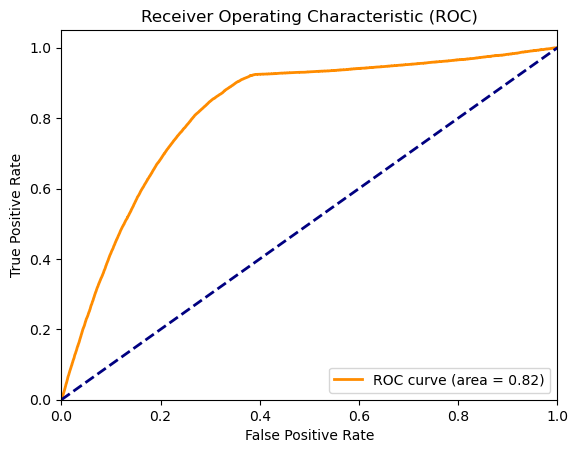

In [7]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Get probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]
# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [8]:
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.7023510582521593
              precision    recall  f1-score   support

           0       0.97      0.67      0.79    121723
           1       0.34      0.88      0.49     23233

    accuracy                           0.70    144956
   macro avg       0.65      0.77      0.64    144956
weighted avg       0.87      0.70      0.74    144956



The accuracy has decreased from 83.9% to 70.2%.  

The recall for Class 0 (smokers/non-smokers) has significantly decreased, meaning the model now misses more smokers/non-smokers, classifying them as previous smokers. This is a direct consequence of lowering the threshold to capture more of the minority class (previous smokers).  

Precision for Class 1 (previous smokers) is 0.34 indicates that when the model predicts someone is a previous smoker, it is correct only 34% of the time. This is a decrease in precision, as the model now falsely identifies more smokers/non-smokers as previous smokers due to the lower threshold.  

The recall for Class 1 (previous smokers) is has significantly increased (0.88), indicating that the model is now much better at identifying previous smokers. This was the intended effect of adjusting the threshold—increasing sensitivity to the minority class.  

# Random Forest

Do cross validation on a simple tree model to find the optimal tree size for random forest.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import f1_score

param_grid = {
    'max_depth': range(20, 35),  # Exploring tree depths from 20 to 34
}
dt = DecisionTreeClassifier(random_state=42)  # Ensuring reproducibility
scorer = make_scorer(f1_score, pos_label=1)

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")
print(f"Best cross-validation f1: {best_score}")

Best Parameters: {'max_depth': 31}
Best cross-validation f1: 0.3337862921679872


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

rf_model = RandomForestClassifier(n_estimators=500, max_depth = 30, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8400480145699385

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.99      0.91    121723
           1       0.51      0.05      0.09     23233

    accuracy                           0.84    144956
   macro avg       0.68      0.52      0.50    144956
weighted avg       0.79      0.84      0.78    144956



In [11]:
feature_importances = rf_model.feature_importances_
features_and_importances = zip(feature_names, feature_importances)

# Sorting the features by importance
sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Printing the sorted features and their importances
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")

sex: 0.0835838104618713
hemoglobin: 0.06289620962461974
triglyceride: 0.054023029218293134
age: 0.05121253055797148
waistline: 0.050985944832753434
Liver_Enzyme_Ratio: 0.050547436625866506
tot_chole: 0.049829295894568484
LDL_chole: 0.04955916395736836
gamma_GTP: 0.04859711296393538
HDL_chole: 0.047527304278117834
BLDS: 0.046628740537677384
MAP: 0.04441902775327541
height: 0.04341089851202441
SBP: 0.04132388487233672
SGOT_ALT: 0.03941082300815931
DBP: 0.03743597004322328
SGOT_AST: 0.037304592818520874
serum_creatinine: 0.0360624532862163
BMI: 0.03179096414160953
weight: 0.028621907244445053
sight_left: 0.027563061378225936
sight_right: 0.027503787180333854
urine_protein: 0.004455301946235125
hear_left: 0.002277845597509935
hear_right: 0.0021364708725585394
Anemia_Indicator: 0.000892432392282754


## Find optimal decision threshold

**Method 1: Maximizing the Difference Between TPR and FPR**

In [12]:
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]

AUC Score: 0.8288961600064578
Optimal Threshold: 0.18048253043824342


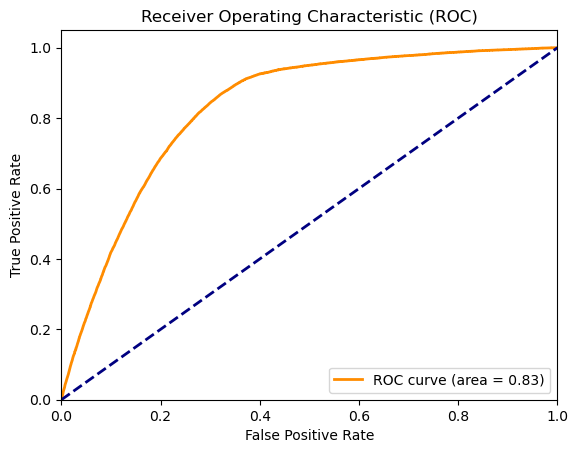

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_rf)
auc_score = roc_auc_score(y_test, y_probs_rf)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Maximizing the Geometric Mean (G-Mean) of Sensitivity and Specificity**

The G-Mean provides a balance between sensitivity and specificity, treating both equally. It is particularly useful when you're dealing with imbalanced classes or when both false positives and false negatives are costly. The geometric mean helps ensure that neither sensitivity nor specificity is disproportionately low.

In [14]:
# Calculate the G-mean for each threshold, which balances sensitivity and specificity
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print('Best Threshold=%f' % (optimal_threshold))

Best Threshold=0.202094


In [15]:
y_pred_optimal = (y_probs_rf >= 0.20).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.7215016970666961
              precision    recall  f1-score   support

           0       0.96      0.70      0.81    121723
           1       0.35      0.85      0.49     23233

    accuracy                           0.72    144956
   macro avg       0.65      0.77      0.65    144956
weighted avg       0.86      0.72      0.76    144956



# Comparison Logistic vs Random Forest (Adjusted threshold)

**Random Forest (Adjusted)**

Accuracy: 0.7215

Precision for Class 0: 0.96

Recall for Class 0: 0.70

F1-Score for Class 0: 0.81

Precision for Class 1: 0.35

Recall for Class 1: 0.85

F1-Score for Class 1: 0.49

Macro Avg F1-Score: 0.65

Weighted Avg F1-Score: 0.76

**Logistic Regression (Adjusted)**

Accuracy: 0.7023

Precision for Class 0: 0.97

Recall for Class 0: 0.67

F1-Score for Class 0: 0.79

Precision for Class 1: 0.34

Recall for Class 1: 0.88

F1-Score for Class 1: 0.49

Macro Avg F1-Score: 0.64

Weighted Avg F1-Score: 0.74

**Accuracy**: The Random Forest model shows a slightly higher accuracy (0.7215 vs. 0.7023) than the Logistic Regression model.

**Precision and Recall for Class 0 (Majority)**: The Random Forest model has similar precision but slightly higher recall for the majority class, leading to a higher F1-score.

**Precision and Recall for Class 1 (Minority)**: Both models have similar precision for the minority class, but the Random Forest model has a slightly lower recall (0.85 vs. 0.88). Despite this, the Random Forest model's F1-score for Class 1 is identical to that of the Logistic Regression model, indicating similar performance in balancing precision and recall for the minority class.

**Macro and Weighted F1-Scores**: The Random Forest model achieves a slightly higher macro avg F1-score (0.65 vs. 0.64) and weighted avg F1-score (0.76 vs. 0.74), indicating a marginally better overall balance between precision and recall across classes.

The adjusted Random Forest model is slightly better than the adjusted Logistic Regression model in terms of overall accuracy and the balance between precision and recall as reflected in the macro and weighted F1-scores. The improvement is particularly noticeable in the recall for the majority class, which contributes to the higher overall accuracy.

In [16]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the classifier to the training set
xgb_clf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = xgb_clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy")
print(accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy
0.8400549132150446
              precision    recall  f1-score   support

           0       0.85      0.98      0.91    121723
           1       0.51      0.10      0.16     23233

    accuracy                           0.84    144956
   macro avg       0.68      0.54      0.54    144956
weighted avg       0.80      0.84      0.79    144956



In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Convert the dataset into an optimized data structure called DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define initial best params and MAE
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': .3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective': 'binary:logistic',
}

# Define the range of hyperparameters to tune
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3, 10)
    for min_child_weight in range(1, 6)
]

min_logloss = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=100,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_logloss = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\tLogLoss {} for {} rounds".format(mean_logloss, boost_rounds))
    if mean_logloss < min_logloss:
        min_logloss = mean_logloss
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, LogLoss: {}".format(best_params[0], best_params[1], min_logloss))

CV with max_depth=3, min_child_weight=1
	LogLoss 0.3313494194187011 for 99 rounds
CV with max_depth=3, min_child_weight=2
	LogLoss 0.3313342894400221 for 94 rounds
CV with max_depth=3, min_child_weight=3
	LogLoss 0.3313025186077053 for 93 rounds
CV with max_depth=3, min_child_weight=4
	LogLoss 0.3313553052365768 for 81 rounds
CV with max_depth=3, min_child_weight=5
	LogLoss 0.3313649805101663 for 86 rounds
CV with max_depth=4, min_child_weight=1
	LogLoss 0.3313939303361889 for 42 rounds
CV with max_depth=4, min_child_weight=2
	LogLoss 0.3313950525442729 for 63 rounds
CV with max_depth=4, min_child_weight=3
	LogLoss 0.3313493978854968 for 46 rounds
CV with max_depth=4, min_child_weight=4
	LogLoss 0.33142543889924025 for 39 rounds
CV with max_depth=4, min_child_weight=5
	LogLoss 0.3314020993948761 for 40 rounds
CV with max_depth=5, min_child_weight=1
	LogLoss 0.33153803326940656 for 24 rounds
CV with max_depth=5, min_child_weight=2
	LogLoss 0.33156014959003727 for 30 rounds
CV with max_d

In [25]:
best_params = {
    'max_depth': 3,
    'min_child_weight': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False
}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
num_boost_round = 1000  # Starting with a large number and using early stopping
early_stopping_rounds = 50  # Stop if no improvement after this many rounds

model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],  # Optional: Include a test set for early stopping
    early_stopping_rounds=early_stopping_rounds
)

print("Best model trained with logloss:", model.best_score)

[0]	Test-logloss:0.40266
[1]	Test-logloss:0.37782
[2]	Test-logloss:0.36277
[3]	Test-logloss:0.35301
[4]	Test-logloss:0.34670
[5]	Test-logloss:0.34261
[6]	Test-logloss:0.33985
[7]	Test-logloss:0.33814
[8]	Test-logloss:0.33691
[9]	Test-logloss:0.33617
[10]	Test-logloss:0.33566
[11]	Test-logloss:0.33526
[12]	Test-logloss:0.33497
[13]	Test-logloss:0.33478
[14]	Test-logloss:0.33459
[15]	Test-logloss:0.33445
[16]	Test-logloss:0.33428
[17]	Test-logloss:0.33419
[18]	Test-logloss:0.33405
[19]	Test-logloss:0.33400
[20]	Test-logloss:0.33394
[21]	Test-logloss:0.33386
[22]	Test-logloss:0.33381
[23]	Test-logloss:0.33373
[24]	Test-logloss:0.33371
[25]	Test-logloss:0.33368
[26]	Test-logloss:0.33362
[27]	Test-logloss:0.33359
[28]	Test-logloss:0.33356
[29]	Test-logloss:0.33352
[30]	Test-logloss:0.33346
[31]	Test-logloss:0.33340
[32]	Test-logloss:0.33337
[33]	Test-logloss:0.33332
[34]	Test-logloss:0.33330
[35]	Test-logloss:0.33324
[36]	Test-logloss:0.33322
[37]	Test-logloss:0.33320
[38]	Test-logloss:0.33

In [26]:
y_probs_xgb = model.predict(dtest)

AUC Score: 0.8350491199447146
Optimal Threshold: 0.15718868374824524


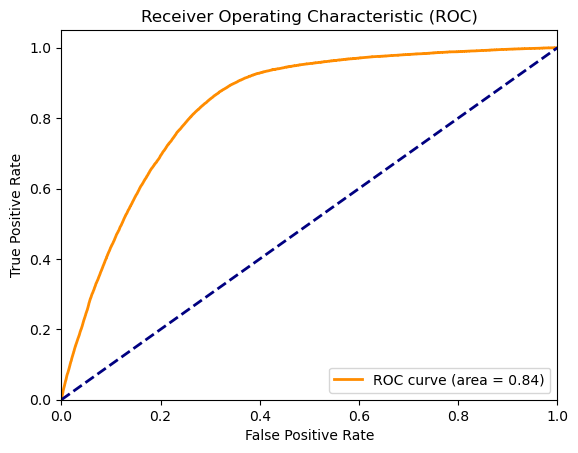

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc_score = roc_auc_score(y_test, y_probs_xgb)
print(f"AUC Score: {auc_score}")
# Calculate ROC curve
roc_auc = auc(fpr, tpr)
# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [28]:
# Calculate the G-mean for each threshold, which balances sensitivity and specificity
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
optimal_threshold = thresholds[ix]
print('Best Threshold=%f' % (optimal_threshold))

Best Threshold=0.193987


In [30]:
y_pred_optimal = (y_probs_xgb >= 0.19).astype(int)

print('accuracy')
print(accuracy_score(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

accuracy
0.7306286045420679
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    121723
           1       0.36      0.84      0.50     23233

    accuracy                           0.73    144956
   macro avg       0.66      0.78      0.66    144956
weighted avg       0.86      0.73      0.77    144956



In [31]:
logistic_regression_metrics = {
    'Model': 'Logistic Regression',
    'Accuracy': 0.7024,
    'Precision (Class 1)': 0.34,
    'Recall (Class 1)': 0.88,
    'F1-Score (Class 1)': 0.49,
    'macro f1': 0.64,
    'weighted f1': 0.74 
}


random_forest_metrics = {
    'Model': 'Random Forest',
    'Accuracy': 0.7215,
    'Precision (Class 1)': 0.35,
    'Recall (Class 1)': 0.85,
    'F1-Score (Class 1)': 0.49,
    'macro f1': 0.65,
    'weighted f1': 0.76
}

xgboost_metrics = {
    'Model': 'XGBoost',
    'Accuracy': 0.7306,
    'Precision (Class 1)': 0.36,
    'Recall (Class 1)': 0.84,
    'F1-Score (Class 1)': 0.50,
    'macro f1': 0.66,
    'weighted f1': 0.77
}

# Creating a DataFrame
results_df = pd.DataFrame([logistic_regression_metrics, random_forest_metrics, xgboost_metrics])

# Displaying the DataFrame for comparison
results_df

,Model,Accuracy,Precision (Class 1),Recall (Class 1),F1-Score (Class 1),macro f1,weighted f1
0,Logistic Regression,0.7024,0.34,0.88,0.49,0.64,0.74
1,Random Forest,0.7215,0.35,0.85,0.49,0.65,0.76
2,XGBoost,0.7306,0.36,0.84,0.50,0.66,0.77


Overall XGBoost performs the best in terms of overall accuracy (73.06%), followed by Random Forest (72.15%) and Logistic Regression (70.24%). XGBoost also leads in precision for Class 1 (0.36), albeit marginally, compared to Random Forest (0.35) and Logistic Regression (0.34).   

Logistic Regression has the highest recall for Class 1 (0.88), indicating it is best at identifying all relevant instances of Class 1 in the dataset. XGBoost and Random Forest follow closely with recalls of 0.84 and 0.85, respectively.  